# Forecasting with ARMA Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/05-ARMA-Fitting-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>


In [ ]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
phi_2 = -0.6
theta_1 = 0.6  # MA coefficient
theta_2 = -0.4
sigma = 1  # standard deviation of noise
n = 100

noise = arma_generate_sample(ar=[1], ma=[1], nsample=n, scale=sigma)

dt = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=1.5 * sigma)

## Fitting AR(p) Models

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where $e_t \sim N(0, \sigma_e^2), E(e_t e_{t-k}) = 0 \text{ for } k \neq 0$.

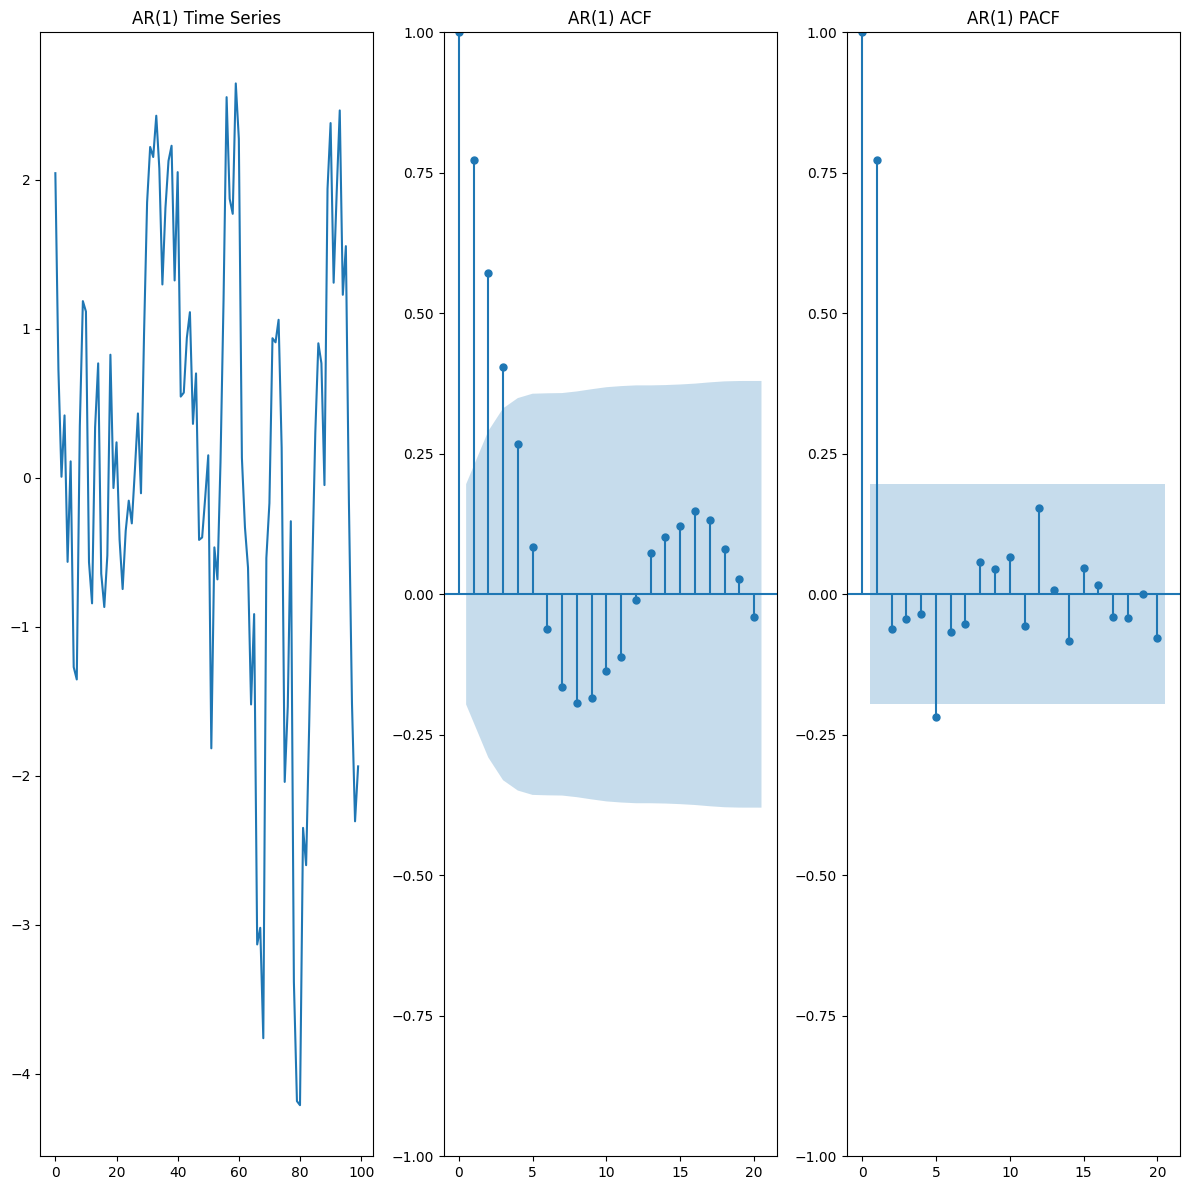

In [ ]:
# Plot the ar1 series and its ACF and PACF

fix, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].plot(dt)
ax[0].set_title('AR(1) Time Series')
plot_acf(dt, ax=ax[1], lags=20)
ax[1].set_title('AR(1) ACF')
plot_pacf(dt, ax=ax[2], lags=20)
ax[2].set_title('AR(1) PACF')
plt.tight_layout()
plt.show()

In [ ]:
# Use statsmodels to fit an AR(1) model and print the summary

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

model_ar1 = ARIMA(dt, order=(1, 0, 0))
model_ar1_fit = model_ar1.fit()

print(model_ar1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -138.314
Date:                Mon, 17 Nov 2025   AIC                            282.628
Time:                        09:10:56   BIC                            290.444
Sample:                             0   HQIC                           285.791
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0995      0.470      0.212      0.832      -0.821       1.020
ar.L1          0.7907      0.058     13.517      0.000       0.676       0.905
sigma2         0.9218      0.124      7.447      0.0

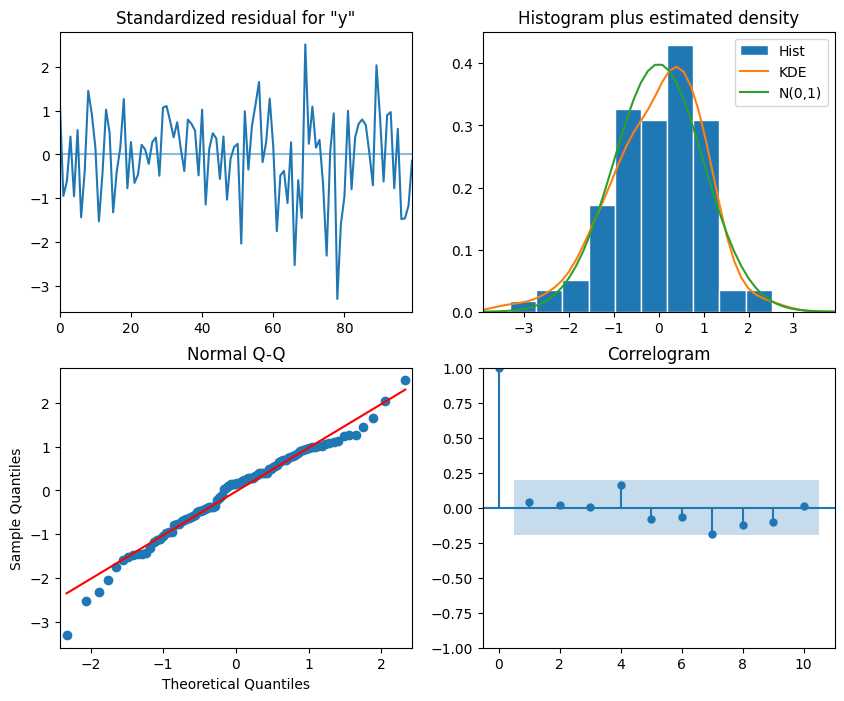

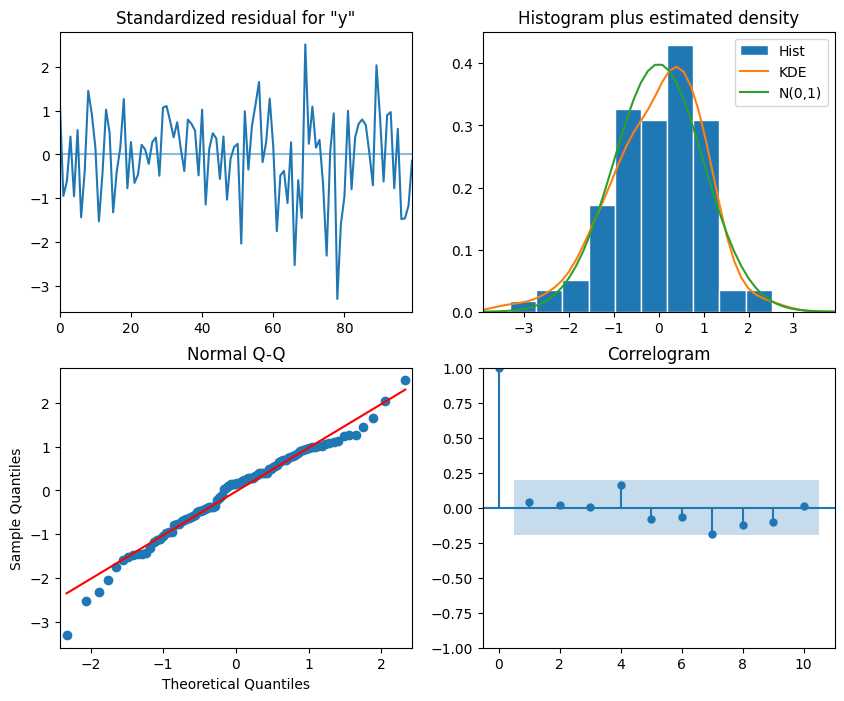

In [7]:
model_ar1_fit.plot_diagnostics(figsize=(10, 8))

## The Jung-Box Test

$$
Q=T(T+2)\sum _{k=1}^{h}{\frac {{\hat {\rho }}_{k}^{2}}{T-k}} \underset{H_0}{\sim} \chi(h)
$$

$$
\begin{align*}
H_0: & \rho_1 = \rho_2 = \ldots = \rho_{h} \\
H_1: & \text{ at least one of } \rho_k \neq 0, \quad k = 1,\ldots, h
\end{align*}
$$

In [20]:
lb_serial_corr = model_ar1_fit.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i + 1}, test statistic = {stat:.3f} with p-value {p:.3f}")

Lag 1, test statistic = 0.188 with p-value 0.664
Lag 2, test statistic = 0.240 with p-value 0.887
Lag 3, test statistic = 0.240 with p-value 0.971
Lag 4, test statistic = 2.981 with p-value 0.561
Lag 5, test statistic = 3.732 with p-value 0.589
Lag 6, test statistic = 4.233 with p-value 0.645
Lag 7, test statistic = 8.122 with p-value 0.322
Lag 8, test statistic = 9.729 with p-value 0.285
Lag 9, test statistic = 10.888 with p-value 0.283
Lag 10, test statistic = 10.907 with p-value 0.365


In [45]:
forecast = model_ar1_fit.get_forecast(steps=2)

print("Forecasts")
print(forecast.predicted_mean)

print("Standard errors")
print(forecast.se_mean)

Forecasts
[-1.51162983 -1.17435725]
Standard errors
[0.96010956 1.22395964]


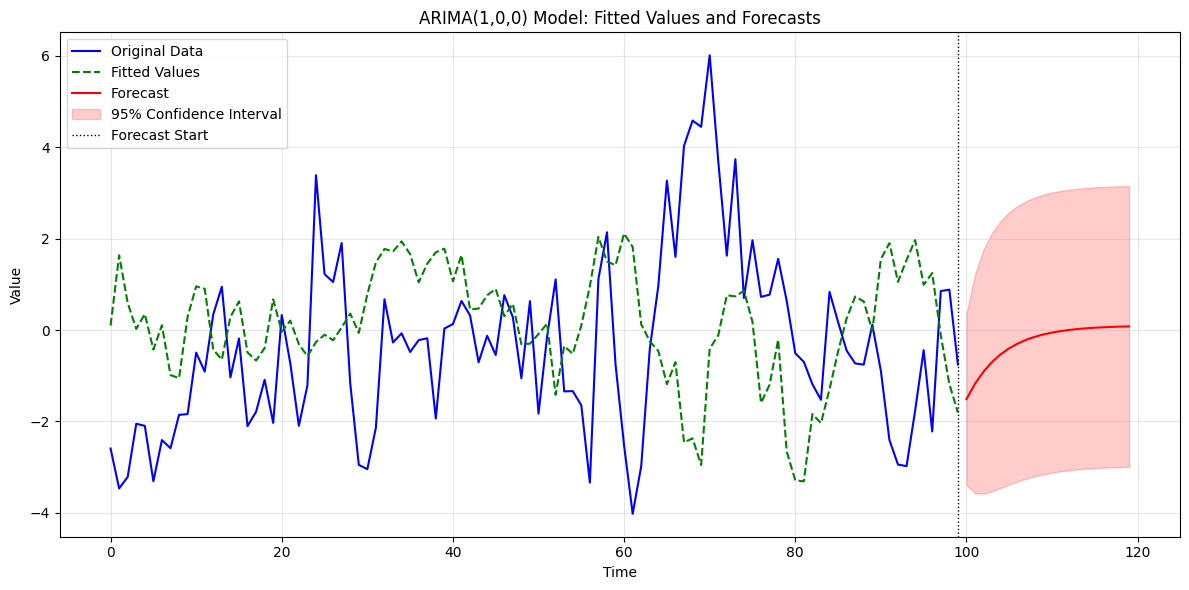

In [36]:
# Plot the prediction of the model

# Get in-sample fitted values
fitted_values = model_ar1_fit.fittedvalues

# Get out-of-sample forecasts (e.g., 20 steps ahead)
forecast_steps = 20
forecast = model_ar1_fit.forecast(steps=forecast_steps)
forecast_index = np.arange(len(dt), len(dt) + forecast_steps)

# Get forecast confidence intervals
forecast_result = model_ar1_fit.get_forecast(steps=forecast_steps)
forecast_ci = np.array(forecast_result.conf_int())  # Convert to numpy array

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dt, label='Original Data', color='blue', linewidth=1.5)
plt.plot(fitted_values, label='Fitted Values', color='green', linewidth=1.5, linestyle='--')
plt.plot(forecast_index, forecast, label='Forecast', color='red', linewidth=1.5)
plt.fill_between(forecast_index, 
                 forecast_ci[:, 0], 
                 forecast_ci[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=len(dt)-1, color='black', linestyle=':', linewidth=1, label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA(1,0,0) Model: Fitted Values and Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Information Criteria

### Akaike Information Criterion (AIC)

$$
AIC = -2 \underbrace{\log(L)}_{\text{Goodness of fit}} + 2 \underbrace{(p + q + k + 1)}_{\text{number of parameters}}
$$


$$
AICc = AIC + \frac{2(p + q + k + 1)(p + q + k + 2)}{T - p - q - k - 2}
$$

$$
BIC = AIC + (\log(T) - 2)(p + q + k + 1)
$$

